### 1. Data source: Rashid SoH-from-EIS dataset

For this notebook I use the public dataset:

> Rashid, Muhammad; Faraji-Niri, Mona; Sansom, Jonathan; Sheikh, Muhammad; Widanage, Dhammika; Marco, James (2023),  
> **“Dataset for rapid state of health estimation of lithium batteries using EIS and machine learning: Training and validation”**,  
> *Data in Brief*, 48, 109157, doi: 10.1016/j.dib.2023.109157.  
> Original data: **“DIB_Data”**, Mendeley Data, V3, doi: 10.17632/mn9fb7xdx6.3 (license: **CC0 1.0**).

Dataset highlights:

- 25 cylindrical Li-ion cells, aged from **SoH 100% down to 80%** in 5 steps (100, 95, 90, 85, 80%).
- At each SoH stage, reference performance tests (capacity / SoH) and **electrochemical impedance spectroscopy (EIS)** at multiple SOC and temperature conditions.
- Designed specifically to study **fast SoH estimation from EIS with machine learning**.

In this notebook I will:

- Build a **tidy table of EIS measurements** with associated SoH, SOC and temperature.
- Engineer compact **impedance features** (real/imaginary parts, magnitude, phase at selected frequencies).
- Train and evaluate **SoH regression models** using these EIS features.

Folder structure in this repo (after placing the dataset under `./data/`):

- `../data/DIB_Data/`
  - `.csvfiles/`
    - `Capacity_Check/` — capacity check results as CSV/Excel files.
    - `EIS_Test/` — EIS measurements as Excel (`.xls`) files (used in this notebook).
  - `.matfiles/`
    - `Capacity_Check/` — capacity check results as MATLAB files.
    - `EIS_Test/` — EIS measurements as MATLAB files (not used here).
  - `WholeDataRealSOH.mat` — MATLAB table summarising all tests (not used here).
  - `CapacityVsCycleNumber.xlsx` — capacity vs cycle reference.
  - `Table 1.docx` — description of the experimental matrix and test conditions.


### 2. EIS files: indexing & loading

In this section I locate all EIS test files, extract their metadata from the filenames,
and load the spectra into a single long-format table.

#### 2.1 List EIS test files

EIS measurements are stored as Excel files under:

- `../data/DIB_Data/.csvfiles/EIS_Test/`

Each file corresponds to one EIS test at a specific (cell, SoH, SOC, temperature).

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

DATA_ROOT = Path("../data/DIB_Data")
EIS_XLS_DIR = DATA_ROOT / ".csvfiles" / "EIS_Test"

def parse_eis_filename(path: Path) -> dict:
    """
    Parse an EIS filename of the form:
    Cell02_95SOH_15degC_05SOC_9505.xls
    """
    stem = path.stem  # drop extension
    parts = stem.split("_")
    if len(parts) != 5:
        raise ValueError(f"Unexpected EIS filename format: {path.name}")

    cell_str, soh_str, temp_str, soc_str, cap_str = parts

    cell_id = int(cell_str.replace("Cell", ""))
    soh_pct = int(soh_str.replace("SOH", ""))
    temp_c = int(temp_str.replace("degC", ""))
    soc_pct = int(soc_str.replace("SOC", ""))
    capacity_code = int(cap_str)

    return {
        "filepath": path,
        "cell_id": cell_id,
        "soh_pct": soh_pct,
        "temp_c": temp_c,
        "soc_pct": soc_pct,
        "capacity_code": capacity_code,
    }

eis_files = sorted(EIS_XLS_DIR.glob("*.xls"))
len(eis_files)


360

#### 2.2 Parse metadata from filenames

Filenames follow the pattern:

`Cell02_95SOH_15degC_05SOC_9505.xls`

From which I extract:

- `cell_id`   → `02`
- `soh_pct`   → `95`
- `temp_c`    → `15`
- `soc_pct`   → `05`
- `capacity_code` → `9505` (numeric code related to capacity / SoH, kept as extra metadata)


In [2]:
eis_index_records = [parse_eis_filename(p) for p in eis_files]
eis_index_df = pd.DataFrame(eis_index_records)

eis_index_df.head()


,filepath,cell_id,soh_pct,temp_c,soc_pct,capacity_code
0,../data/DIB_Data/.csvfiles/EIS_Test/Cell02_95S...,2,95,15,5,9505
1,../data/DIB_Data/.csvfiles/EIS_Test/Cell02_95S...,2,95,15,20,9505
2,../data/DIB_Data/.csvfiles/EIS_Test/Cell02_95S...,2,95,15,50,9505
3,../data/DIB_Data/.csvfiles/EIS_Test/Cell02_95S...,2,95,15,70,9505
4,../data/DIB_Data/.csvfiles/EIS_Test/Cell02_95S...,2,95,15,95,9505


#### 2.3 Sanity checks on metadata

I check that:

- There are 360 EIS tests in total.
- SoH, SOC and temperature cover the expected grids.
- There are multiple cells, so I can later split by `cell_id`.

In [3]:
print("Number of EIS tests:", len(eis_index_df))

print("\nUnique cells:", sorted(eis_index_df["cell_id"].unique()))
print("\nUnique SoH levels:", sorted(eis_index_df["soh_pct"].unique()))
print("\nUnique temperatures (°C):", sorted(eis_index_df["temp_c"].unique()))
print("\nUnique SOC levels (%):", sorted(eis_index_df["soc_pct"].unique()))


Number of EIS tests: 360

Unique cells: [np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32)]

Unique SoH levels: [np.int64(80), np.int64(85), np.int64(90), np.int64(95), np.int64(100)]

Unique temperatures (°C): [np.int64(15), np.int64(25), np.int64(35)]

Unique SOC levels (%): [np.int64(5), np.int64(20), np.int64(50), np.int64(70), np.int64(95)]


#### 2.4 Load EIS spectra

Each EIS file contains one spectrum with three columns:

- column 1: frequency (Hz),
- column 2: real part of impedance Re(Z) (Ω),
- column 3: imaginary part of impedance Im(Z) (Ω).

I load all 360 files into a single long-format DataFrame where each row is a
single (cell, SoH, SOC, T, frequency) point:

- `cell_id, soh_pct, temp_c, soc_pct, capacity_code`
- `frequency_hz, z_real_ohm, z_imag_ohm`

In [4]:
example_path = eis_index_df.loc[0, "filepath"]
example_path


PosixPath('../data/DIB_Data/.csvfiles/EIS_Test/Cell02_95SOH_15degC_05SOC_9505.xls')

In [5]:
example_raw = pd.read_excel(example_path, header=None)
example_raw.head(), example_raw.shape


(         0        1        2
 0  10000.0  0.02995  0.03160
 1   7943.0  0.02827  0.02617
 2   6310.0  0.02704  0.02143
 3   5012.0  0.02599  0.01736
 4   3981.0  0.02499  0.01377,
 (61, 3))

In [6]:
def load_single_eis(path: Path) -> pd.DataFrame:
    """
    Load one EIS .xls file and return a DataFrame with columns:
    frequency_hz, z_real_ohm, z_imag_ohm.

    Any non-numeric rows (e.g. accidental headers) are dropped after
    coercing to numeric.
    """
    df = pd.read_excel(path, header=None)

    # Keep first three columns and assign names
    df = df.iloc[:, :3].copy()
    df.columns = ["frequency_hz", "z_real_ohm", "z_imag_ohm"]

    # Coerce to numeric and drop non-numeric rows
    for col in ["frequency_hz", "z_real_ohm", "z_imag_ohm"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    df = df.dropna(subset=["frequency_hz", "z_real_ohm", "z_imag_ohm"])

    df = df.astype(
        {
            "frequency_hz": float,
            "z_real_ohm": float,
            "z_imag_ohm": float,
        }
    )

    return df


In [7]:
def load_all_eis(eis_index: pd.DataFrame) -> pd.DataFrame:
    """
    Load all EIS spectra listed in eis_index into a single long-format DataFrame.

    Output columns:
    - cell_id, soh_pct, temp_c, soc_pct, capacity_code
    - frequency_hz, z_real_ohm, z_imag_ohm
    """
    all_records = []

    for _, meta in eis_index.iterrows():
        spec = load_single_eis(meta["filepath"])

        # Attach metadata
        for col in ["cell_id", "soh_pct", "temp_c", "soc_pct", "capacity_code"]:
            spec[col] = meta[col]

        all_records.append(spec)

    return pd.concat(all_records, ignore_index=True)

eis_long_df = load_all_eis(eis_index_df)
eis_long_df.head()


,frequency_hz,z_real_ohm,z_imag_ohm,cell_id,soh_pct,temp_c,soc_pct,capacity_code
0,10000.0,0.02995,0.03160,2,95,15,5,9505
1,7943.0,0.02827,0.02617,2,95,15,5,9505
2,6310.0,0.02704,0.02143,2,95,15,5,9505
3,5012.0,0.02599,0.01736,2,95,15,5,9505
4,3981.0,0.02499,0.01377,2,95,15,5,9505


In [8]:
print(eis_long_df.shape)
eis_long_df.describe().T.head(10)


(21960, 8)


,count,mean,std,min,25%,50%,75%,max
frequency_hz,21960.0,797.097582,1951.144325,0.01000,0.316200,10.000000,316.200000,10000.00000
z_real_ohm,21960.0,0.029719,0.007403,0.02261,0.025330,0.027710,0.031280,0.08710
z_imag_ohm,21960.0,0.000229,0.007416,-0.03523,-0.002455,-0.001167,-0.000125,0.03542
cell_id,21960.0,18.291667,9.149339,2.00000,12.750000,19.500000,25.250000,32.00000
soh_pct,21960.0,90.000000,7.217043,80.00000,85.000000,90.000000,95.000000,100.00000
temp_c,21960.0,25.000000,8.165152,15.00000,15.000000,25.000000,35.000000,35.00000
soc_pct,21960.0,48.000000,32.650399,5.00000,20.000000,50.000000,70.000000,95.00000
capacity_code,21960.0,9034.750000,721.318964,8046.00000,8307.250000,9067.000000,9612.750000,10000.00000


In [9]:
n_freq_per_test = (
    eis_long_df.groupby(["cell_id", "soh_pct", "temp_c", "soc_pct"])
    ["frequency_hz"]
    .nunique()
)

n_freq_per_test.value_counts()


frequency_hz
61    360
Name: count, dtype: int64

#### 2.5 Final count of complete EIS tests

Here I summarise how many **distinct EIS tests** I have after loading and basic cleaning,
and how this compares to the dataset description:

- number of cells,
- number of EIS tests (unique combinations of cell, SoH, SOC, temperature),
- SoH / SOC / temperature grids,
- typical number of frequency points per spectrum.


In [10]:
# One row per unique EIS test (cell, SoH, T, SOC)
tests_df = (
    eis_long_df
    .groupby(["cell_id", "soh_pct", "temp_c", "soc_pct"], as_index=False)
    .agg(
        n_points=("frequency_hz", "size"),
        n_freq=("frequency_hz", "nunique"),
    )
)

n_cells = tests_df["cell_id"].nunique()
n_tests = len(tests_df)

soh_levels = sorted(tests_df["soh_pct"].unique())
soc_levels = sorted(tests_df["soc_pct"].unique())
temp_levels = sorted(tests_df["temp_c"].unique())

# If all spectra have the same number of frequency points, report that
if tests_df["n_freq"].nunique() == 1:
    freq_points_per_spectrum = int(tests_df["n_freq"].iloc[0])
else:
    freq_points_per_spectrum = f"varies ({tests_df['n_freq'].min()}–{tests_df['n_freq'].max()})"

summary_table = pd.DataFrame(
    {
        "n_cells": [n_cells],
        "n_eis_tests": [n_tests],
        "soh_levels": [", ".join(str(x) for x in soh_levels)],
        "soc_levels": [", ".join(str(x) for x in soc_levels)],
        "temp_levels": [", ".join(str(x) for x in temp_levels)],
        "freq_points_per_spectrum": [freq_points_per_spectrum],
    }
)

summary_table


,n_cells,n_eis_tests,soh_levels,soc_levels,temp_levels,freq_points_per_spectrum
0,24,360,"80, 85, 90, 95, 100","5, 20, 50, 70, 95","15, 25, 35",61


### 3. SoH labels & basic exploration

In this dataset the SoH label is already encoded in the EIS filenames as a
discrete percentage:

- `soh_pct ∈ {80, 85, 90, 95, 100}`.

For the modelling part I will:

- use `soh_pct` (or `soh_frac = soh_pct / 100`) as the main regression target,
- treat SOC (`soc_pct`) and temperature (`temp_c`) as context features alongside
  the impedance features.

Later in the notebook I will also derive a simple **healthy vs aged** label
(e.g. based on a SoH threshold such as 90%) to:

- reuse the SoH regression model as a scoring function,
- compute ROC and precision–recall curves,
- and report classification-style metrics such as FPR and FNR for that binary
  decision.

In this section I keep the exploration minimal and focus on two checks:

1. A histogram of SoH values across all EIS tests  
   → shows how many spectra are available at each SoH level.

2. A 1×3 bar-plot figure (“Cells per (SoH, SOC) combination at each temperature”)  
   → summarises how the EIS tests cover the (SoH, SOC, T) grid and how many cells
   contribute to each combination.


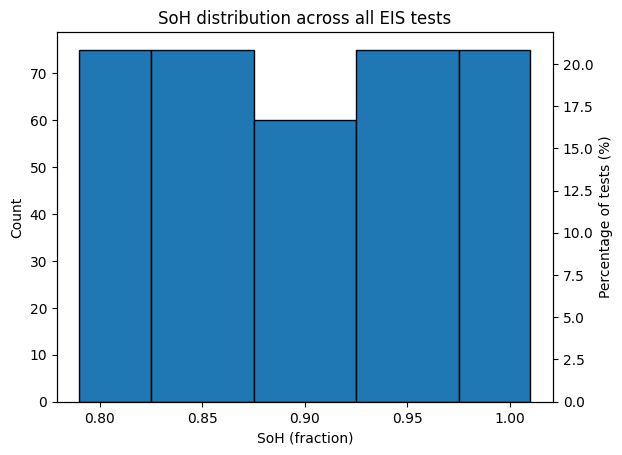

In [11]:
import matplotlib.pyplot as plt

# SoH as fraction in [0, 1] for convenience
tests_df["soh_frac"] = tests_df["soh_pct"] / 100.0

fig, ax = plt.subplots()

# Histogram (counts)
counts, bins, patches = ax.hist(
    tests_df["soh_frac"],
    bins=[0.79, 0.825, 0.875, 0.925, 0.975, 1.01],
    edgecolor="black",
)

ax.set_xlabel("SoH (fraction)")
ax.set_ylabel("Count")
ax.set_title("SoH distribution across all EIS tests")

# Second y-axis for percentages
ax2 = ax.twinx()
total = counts.sum()

# Match the scale: max count on left → corresponding % on right
ax2.set_ylim(0, (ax.get_ylim()[1] / total) * 100)
ax2.set_ylabel("Percentage of tests (%)");


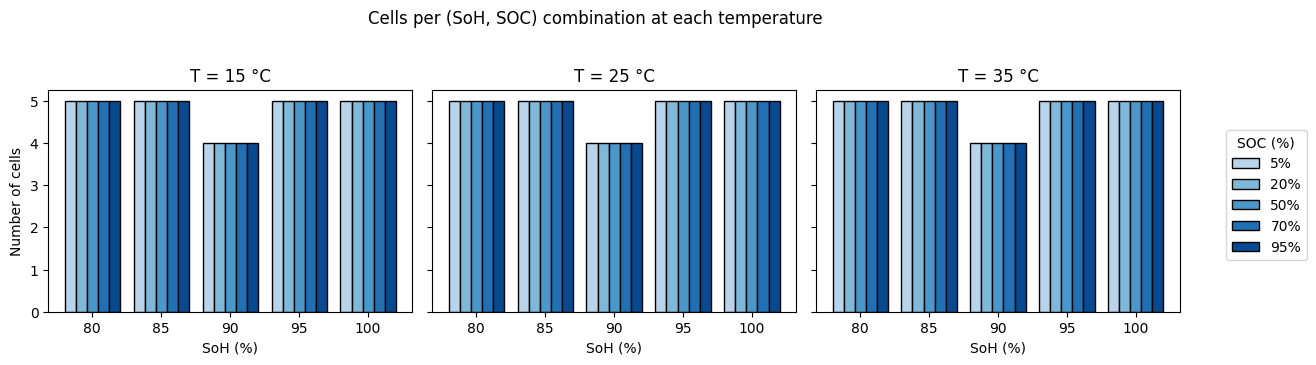

In [12]:
# Counts per (SoH, SOC, T)
grid_counts = (
    tests_df
    .groupby(["soh_pct", "soc_pct", "temp_c"])["cell_id"]
    .nunique()
    .rename("n_cells")
    .reset_index()
)

soh_levels = sorted(grid_counts["soh_pct"].unique())
soc_levels = sorted(grid_counts["soc_pct"].unique())
temp_levels = sorted(grid_counts["temp_c"].unique())

n_temp = len(temp_levels)
fig, axes = plt.subplots(1, n_temp, figsize=(4 * n_temp, 3.5), sharey=True)

if n_temp == 1:
    axes = [axes]

x = np.arange(len(soh_levels))        # SoH positions on x-axis
width = 0.8 / len(soc_levels)         # total width 0.8, split over SOC levels

# Color gradient for SOC (avoid very light colors)
cmap = plt.get_cmap("Blues")
color_positions = np.linspace(0.3, 0.9, len(soc_levels))  # darker to lighter blues
soc_colors = {soc: cmap(pos) for soc, pos in zip(soc_levels, color_positions)}

for ax, temp in zip(axes, temp_levels):
    sub = grid_counts[grid_counts["temp_c"] == temp]

    # pivot to SoH x SOC → n_cells
    pivot = (
        sub.pivot(index="soh_pct", columns="soc_pct", values="n_cells")
        .reindex(index=soh_levels, columns=soc_levels)
        .fillna(0)
    )

    for i, soc in enumerate(soc_levels):
        counts = pivot[soc].values
        ax.bar(
            x + (i - len(soc_levels) / 2 + 0.5) * width,
            counts,
            width,
            label=f"{soc}%",
            color=soc_colors[soc],
            edgecolor="black",
        )

    ax.set_xticks(x)
    ax.set_xticklabels(soh_levels)
    ax.set_xlabel("SoH (%)")
    ax.set_title(f"T = {temp} °C")

axes[0].set_ylabel("Number of cells")

# Shared legend on the right, vertical
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    title="SOC (%)",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    ncol=1,
)

fig.suptitle("Cells per (SoH, SOC) combination at each temperature", y=1.03)
fig.tight_layout()


### 4. Impedance feature engineering

Each EIS test corresponds to one spectrum:

- 61 frequency points (`frequency_hz`),
- real and imaginary parts of impedance (`z_real_ohm`, `z_imag_ohm`).

For the models I compress each spectrum into a small set of summary features.
Per (cell, SoH, SOC, temperature) test I compute:

- **R_hf_ohm** – real part of Z at the highest frequency (approx. ohmic resistance),
- **R_lf_ohm** – real part of Z at the lowest frequency (approx. total resistance),
- **delta_R_ohm** – `R_lf_ohm - R_hf_ohm`,
- **Zmag_mean / Zmag_std / Zmag_min / Zmag_max** – summary statistics of |Z|,
- **phase_mean / phase_std** – summary statistics of the impedance phase.

On top of these global summaries, I sample the spectrum at a fixed set of
frequencies (in Hz):

- `f_targets = [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]`

For each target frequency I find the closest available frequency in the
measured spectrum and record:

- **Zmag_fX** – magnitude |Z| at that frequency,
- **phase_fX** – phase at that frequency.

This gives a compact “impedance fingerprint” per test that captures both global
behaviour and the shape at a few physically meaningful frequencies.

The result is a modelling table `model_df` with one row per EIS test:

- metadata: `cell_id, soh_pct, soc_pct, temp_c`,
- impedance features: `R_hf_ohm, R_lf_ohm, delta_R_ohm, Zmag_* , phase_*`,
- SoH label for regression: `soh_frac = soh_pct / 100`.


#### Code 4.1 – define grouping and feature function

In [13]:
group_cols = ["cell_id", "soh_pct", "temp_c", "soc_pct"]

def compute_impedance_features(group: pd.DataFrame) -> dict:
    """
    Compute a small set of summary features from one EIS spectrum.

    Per (cell, SoH, T, SOC) test, this returns:
    - R_hf_ohm, R_lf_ohm, delta_R_ohm
    - Zmag_mean / Zmag_std / Zmag_min / Zmag_max
    - phase_mean / phase_std
    - Zmag_f* and phase_f* at a fixed set of target frequencies.
    """
    g = group.sort_values("frequency_hz")

    freq = g["frequency_hz"].to_numpy()
    z_real = g["z_real_ohm"].to_numpy()
    z_imag = g["z_imag_ohm"].to_numpy()
    z_complex = z_real + 1j * z_imag

    mag = np.abs(z_complex)
    phase = np.angle(z_complex)

    # Highest and lowest frequency indices
    idx_hf = np.argmax(freq)
    idx_lf = np.argmin(freq)

    R_hf = z_real[idx_hf]   # approx. ohmic resistance
    R_lf = z_real[idx_lf]   # approx. total resistance

    features = {
        "R_hf_ohm": R_hf,
        "R_lf_ohm": R_lf,
        "delta_R_ohm": R_lf - R_hf,
        "Zmag_mean": float(mag.mean()),
        "Zmag_std": float(mag.std()),
        "Zmag_min": float(mag.min()),
        "Zmag_max": float(mag.max()),
        "phase_mean": float(phase.mean()),
        "phase_std": float(phase.std()),
    }

    # Target frequencies (Hz) at which to sample |Z| and phase
    f_targets = [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]

    for f_target in f_targets:
        # Find index of closest actual frequency
        idx = int(np.argmin(np.abs(freq - f_target)))
        # Safe suffix for column names, e.g. 0.01 -> "f0p01"
        suffix = str(f_target).replace(".", "p")
        features[f"Zmag_f{suffix}"] = float(mag[idx])
        features[f"phase_f{suffix}"] = float(phase[idx])

    return features


#### Code 4.2 – build feature table from all spectra

In [14]:
feature_records = []

for keys, group in eis_long_df.groupby(group_cols):
    feats = compute_impedance_features(group)
    record = dict(zip(group_cols, keys))
    record.update(feats)
    feature_records.append(record)

features_df = pd.DataFrame(feature_records)

features_df.head()


,cell_id,soh_pct,temp_c,soc_pct,R_hf_ohm,R_lf_ohm,delta_R_ohm,Zmag_mean,Zmag_std,Zmag_min,...,Zmag_f1p0,phase_f1p0,Zmag_f10p0,phase_f10p0,Zmag_f100p0,phase_f100p0,Zmag_f1000p0,phase_f1000p0,Zmag_f10000p0,phase_f10000p0
0,2,95,15,5,0.02995,0.07366,0.04371,0.040826,0.016416,0.024201,...,0.042847,-0.282403,0.031430,-0.123542,0.027523,-0.077613,0.024205,0.097449,0.043538,0.812199
1,2,95,15,20,0.03001,0.07916,0.04915,0.041919,0.018060,0.024285,...,0.042731,-0.290515,0.031688,-0.122719,0.027668,-0.079707,0.024291,0.095818,0.043579,0.811200
2,2,95,15,50,0.02965,0.03573,0.00608,0.029907,0.003850,0.023819,...,0.030956,-0.031686,0.029673,-0.047501,0.026807,-0.059273,0.023819,0.103972,0.043398,0.818643
3,2,95,15,70,0.02960,0.03803,0.00843,0.030187,0.004274,0.023747,...,0.030942,-0.037886,0.029639,-0.051610,0.026685,-0.058380,0.023747,0.103440,0.043320,0.818540
4,2,95,15,95,0.02958,0.04171,0.01213,0.031920,0.005565,0.023771,...,0.034760,-0.067860,0.030048,-0.092483,0.026772,-0.062605,0.023772,0.101259,0.043262,0.817930


#### Code 4.3 – construct model_df with SoH label

In [15]:
# Start from the engineered features (one row per EIS test)
model_df = features_df.copy()

# SoH as fraction for regression
model_df["soh_frac"] = model_df["soh_pct"] / 100.0

model_df.head()


,cell_id,soh_pct,temp_c,soc_pct,R_hf_ohm,R_lf_ohm,delta_R_ohm,Zmag_mean,Zmag_std,Zmag_min,...,phase_f1p0,Zmag_f10p0,phase_f10p0,Zmag_f100p0,phase_f100p0,Zmag_f1000p0,phase_f1000p0,Zmag_f10000p0,phase_f10000p0,soh_frac
0,2,95,15,5,0.02995,0.07366,0.04371,0.040826,0.016416,0.024201,...,-0.282403,0.031430,-0.123542,0.027523,-0.077613,0.024205,0.097449,0.043538,0.812199,0.95
1,2,95,15,20,0.03001,0.07916,0.04915,0.041919,0.018060,0.024285,...,-0.290515,0.031688,-0.122719,0.027668,-0.079707,0.024291,0.095818,0.043579,0.811200,0.95
2,2,95,15,50,0.02965,0.03573,0.00608,0.029907,0.003850,0.023819,...,-0.031686,0.029673,-0.047501,0.026807,-0.059273,0.023819,0.103972,0.043398,0.818643,0.95
3,2,95,15,70,0.02960,0.03803,0.00843,0.030187,0.004274,0.023747,...,-0.037886,0.029639,-0.051610,0.026685,-0.058380,0.023747,0.103440,0.043320,0.818540,0.95
4,2,95,15,95,0.02958,0.04171,0.01213,0.031920,0.005565,0.023771,...,-0.067860,0.030048,-0.092483,0.026772,-0.062605,0.023772,0.101259,0.043262,0.817930,0.95


#### 4.4 Coefficient of variation of impedance features

As a quick sanity check I look at the **coefficient of variation (CoV)** of the
engineered impedance features across all EIS tests:

CoV = std / |mean|

Features with higher CoV vary more across the dataset and typically carry more
useful information for the models than almost-constant features.


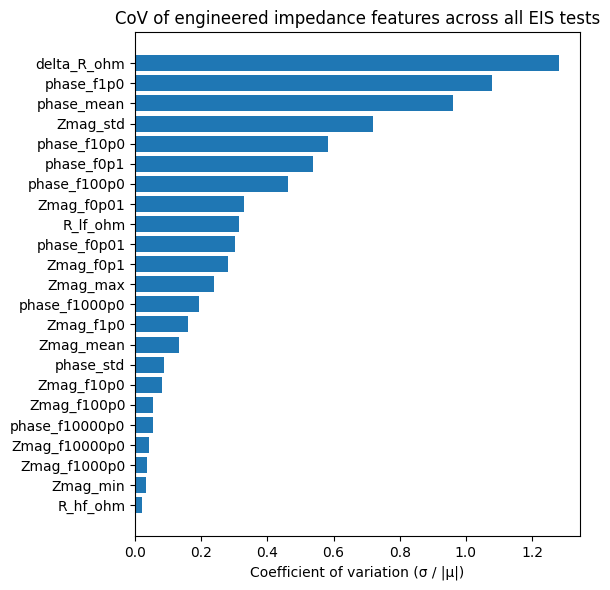

In [16]:
# Impedance feature columns (exclude metadata and target)
feature_cols = [
    c for c in model_df.columns
    if c.startswith(("R_", "Zmag_", "phase_", "delta_"))
]

feature_means = model_df[feature_cols].abs().mean()
feature_stds = model_df[feature_cols].std()

cov = (feature_stds / feature_means).sort_values(ascending=False)
cov_df = cov.to_frame(name="CoV")

fig, ax = plt.subplots(figsize=(6, 6))

ax.barh(range(len(cov_df)), cov_df["CoV"])
ax.set_yticks(range(len(cov_df)))
ax.set_yticklabels(cov_df.index)
ax.invert_yaxis()  # highest CoV at the top

ax.set_xlabel("Coefficient of variation (σ / |μ|)")
ax.set_title("CoV of engineered impedance features across all EIS tests")

fig.tight_layout()


### 5. SoH regression models

In this section I predict SoH from the engineered impedance features.

- **Input features**: impedance features (`R_*`, `Zmag_*`, `phase_*`) plus SOC (`soc_pct`)
  and temperature (`temp_c`).
- **Target**: `soh_frac = soh_pct / 100`.

To avoid leakage between tests from the same physical cell, I use **nested grouped
cross-validation**:

- **Outer loop**: 5-fold `GroupKFold` over `cell_id` (5 “M-fold” splits)  
  → used to estimate model performance and variability across cell splits.
- **Inner loop**: 3-fold `GroupKFold` over `cell_id` inside each outer train split  
  → used to select hyperparameters.

I compare three regression models:

1. **ElasticNet** (linear baseline with L1+L2 regularisation),
2. **XGBoostRegressor** (gradient boosting for tabular data),
3. **GaussianProcessRegressor** (non-parametric Bayesian regression with an RBF kernel).

Later I will take the **best-performing hyperparameters** for each model, refit
on all data, and inspect **feature importance** for ElasticNet and XGBoost.


#### 5.1 Prepare features, target, groups

In [17]:
# Feature columns: impedance features + SOC + temperature
feature_cols = [
    c for c in model_df.columns
    if c.startswith(("R_", "Zmag_", "phase_"))
] + ["soc_pct", "temp_c"]

X = model_df[feature_cols].to_numpy()
y = model_df["soh_frac"].to_numpy()
groups = model_df["cell_id"].to_numpy()

len(feature_cols), X.shape, y.shape


(24, (360, 24), (360,))

#### 5.2 Metrics and hyperparameter grids

In [21]:
from sklearn.model_selection import GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from xgboost import XGBRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from tqdm.auto import tqdm


def regression_metrics(y_true, y_pred):
    """Return MAE, RMSE and R² in a small dict."""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"mae": mae, "rmse": rmse, "r2": r2}

# Simple hyperparameter grids for each model
elasticnet_param_grid = {
    "alpha":    [0.001, 0.01, 0.1, 1.0],
    "l1_ratio": [0.1, 0.5, 0.9],
}

xgb_param_grid = {
    "n_estimators":  [200, 500],
    "max_depth":     [3, 4],
    "learning_rate": [0.05, 0.1],
}

gp_param_grid = {
    "length_scale": [0.1, 1.0, 10.0],
    "noise_level":  [1e-6, 1e-4],
}


#### 5.3 Running the models loop

In [20]:
import itertools

outer_cv = GroupKFold(n_splits=5)
inner_cv = GroupKFold(n_splits=3)

results = []

models = ["ElasticNet", "XGBoost", "GP"]

for model_name in models:
    print(f"\n=== Model: {model_name} ===")
    outer_fold = 0

    for outer_train_idx, outer_val_idx in tqdm(
        outer_cv.split(X, y, groups),
        total=5,
        desc=f"{model_name} outer CV"
    ):
        outer_fold += 1

        X_train_o, X_val_o = X[outer_train_idx], X[outer_val_idx]
        y_train_o, y_val_o = y[outer_train_idx], y[outer_val_idx]
        groups_train_o = groups[outer_train_idx]

        # Choose the param grid for this model
        if model_name == "ElasticNet":
            param_grid = elasticnet_param_grid
        elif model_name == "XGBoost":
            param_grid = xgb_param_grid
        elif model_name == "GP":
            param_grid = gp_param_grid
        else:
            raise ValueError(f"Unknown model: {model_name}")

        # Build list of all param combinations
        grid_keys = list(param_grid.keys())
        grid_values = [param_grid[k] for k in grid_keys]
        param_combinations = []
        for values in itertools.product(*grid_values):
            param_combinations.append(dict(zip(grid_keys, values)))

        best_inner_mae = None
        best_params = None

        # Inner CV: grid search on outer train
        for params in param_combinations:
            inner_maes = []

            for inner_train_idx, inner_val_idx in inner_cv.split(
                X_train_o, y_train_o, groups_train_o
            ):
                X_train_i, X_val_i = (
                    X_train_o[inner_train_idx],
                    X_train_o[inner_val_idx],
                )
                y_train_i, y_val_i = (
                    y_train_o[inner_train_idx],
                    y_train_o[inner_val_idx],
                )

                # Build estimator for this model + params
                if model_name == "ElasticNet":
                    est = Pipeline(
                        [
                            ("scaler", StandardScaler()),
                            (
                                "reg",
                                ElasticNet(
                                    alpha=params["alpha"],
                                    l1_ratio=params["l1_ratio"],
                                    max_iter=10000,
                                    random_state=0,
                                ),
                            ),
                        ]
                    )
                elif model_name == "XGBoost":
                    est = XGBRegressor(
                        n_estimators=params["n_estimators"],
                        max_depth=params["max_depth"],
                        learning_rate=params["learning_rate"],
                        subsample=0.9,
                        colsample_bytree=0.9,
                        objective="reg:squarederror",
                        random_state=0,
                        n_jobs=1,
                    )
                elif model_name == "GP":
                    kernel = RBF(length_scale=params["length_scale"]) + \
                             WhiteKernel(noise_level=params["noise_level"])
                    est = Pipeline(
                        [
                            ("scaler", StandardScaler()),
                            (
                                "reg",
                                GaussianProcessRegressor(
                                    kernel=kernel,
                                    alpha=0.0,
                                    normalize_y=True,
                                    n_restarts_optimizer=2,
                                    random_state=0,
                                ),
                            ),
                        ]
                    )

                # Fit and evaluate on inner validation
                est.fit(X_train_i, y_train_i)
                y_val_pred_i = est.predict(X_val_i)
                mae_i = mean_absolute_error(y_val_i, y_val_pred_i)
                inner_maes.append(mae_i)

            mean_inner_mae = float(np.mean(inner_maes))

            if (best_inner_mae is None) or (mean_inner_mae < best_inner_mae):
                best_inner_mae = mean_inner_mae
                best_params = params

        print(
            f"  Fold {outer_fold}: best inner MAE={best_inner_mae:.4f} "
            f"with params={best_params}"
        )

        # Refit on full outer train with best params
        if model_name == "ElasticNet":
            est_best = Pipeline(
                [
                    ("scaler", StandardScaler()),
                    (
                        "reg",
                        ElasticNet(
                            alpha=best_params["alpha"],
                            l1_ratio=best_params["l1_ratio"],
                            max_iter=10000,
                            random_state=0,
                        ),
                    ),
                ]
            )
        elif model_name == "XGBoost":
            est_best = XGBRegressor(
                n_estimators=best_params["n_estimators"],
                max_depth=best_params["max_depth"],
                learning_rate=best_params["learning_rate"],
                subsample=0.9,
                colsample_bytree=0.9,
                objective="reg:squarederror",
                random_state=0,
                n_jobs=1,
            )
        elif model_name == "GP":
            kernel = RBF(length_scale=best_params["length_scale"]) + \
                     WhiteKernel(noise_level=best_params["noise_level"])
            est_best = Pipeline(
                [
                    ("scaler", StandardScaler()),
                    (
                        "reg",
                        GaussianProcessRegressor(
                            kernel=kernel,
                            alpha=0.0,
                            normalize_y=True,
                            n_restarts_optimizer=2,
                            random_state=0,
                        ),
                    ),
                ]
            )

        est_best.fit(X_train_o, y_train_o)
        y_val_pred = est_best.predict(X_val_o)

        m = regression_metrics(y_val_o, y_val_pred)
        row = {
            "model": model_name,
            "outer_fold": outer_fold,
            "best_params": best_params,
            **m,
        }
        results.append(row)

metrics_df = pd.DataFrame(results)
metrics_df



=== Model: ElasticNet ===


ElasticNet outer CV:   0%|          | 0/5 [00:00<?, ?it/s]

  Fold 1: best inner MAE=0.0379 with params={'alpha': 0.001, 'l1_ratio': 0.1}


TypeError: got an unexpected keyword argument 'squared'